In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the prepared data
try:
    df_scaled = pd.read_csv('../data/processed/nba_2025_player_stats_scaled_for_clustering.csv')
    player_info = pd.read_csv('../data/processed/nba_2025_player_info.csv')

    print("Scaled features head:")
    print(df_scaled.head())
    print("\nPlayer info head:")
    print(player_info.head())
    print(f"\nTotal players for clustering: {len(df_scaled)}")

except FileNotFoundError:
    print("Error: Make sure 'nba_2025_player_stats_scaled_for_clustering.csv' and 'nba_2025_player_info.csv' are in 'data/processed/'")
    exit()

# It's good practice to ensure the indices align if you're going to merge later
# If you saved with index=False, the indices should naturally align after loading.
# If you had different row orders in original dataframes, merging might have reordered them.
# A safe way is to merge the player_info back with the clustered results later.

Scaled features head:
        PTS       AST       TRB       STL       BLK       TOV        PF  \
0  0.219874 -0.103204 -1.177485 -0.811858 -0.359945 -0.458698 -1.571965   
1 -0.603001  0.944976  0.917143  0.589310 -0.614092 -0.001050 -0.423486   
2  2.247671  0.346016 -0.304723 -0.111274 -0.105797  1.463427 -1.130242   
3  1.748069  1.543936 -0.878252 -0.811858 -0.868239  1.097307 -0.335142   
4  1.424797  2.554680 -0.204979  0.764456  0.021276  3.019432 -0.865209   

        FG%       3P%       2P%  ...      BLK%      TOV%      USG%       OWS  \
0  0.465977  0.247549  0.831608  ... -0.396690 -0.691456  0.052407  1.143497   
1  0.839114  0.040330  1.198810  ... -0.661859  0.818912 -0.713998  2.069792   
2 -0.325074  0.652118 -0.591299  ... -0.131520 -0.092517  2.155567  1.633889   
3 -0.116118  0.030463  0.036004  ... -0.927029 -0.118557  1.781276  2.451208   
4 -0.877318  0.227814 -1.035001  ...  0.067357  1.469933  1.834746  1.306961   

        DWS        WS     WS/48       BPM     

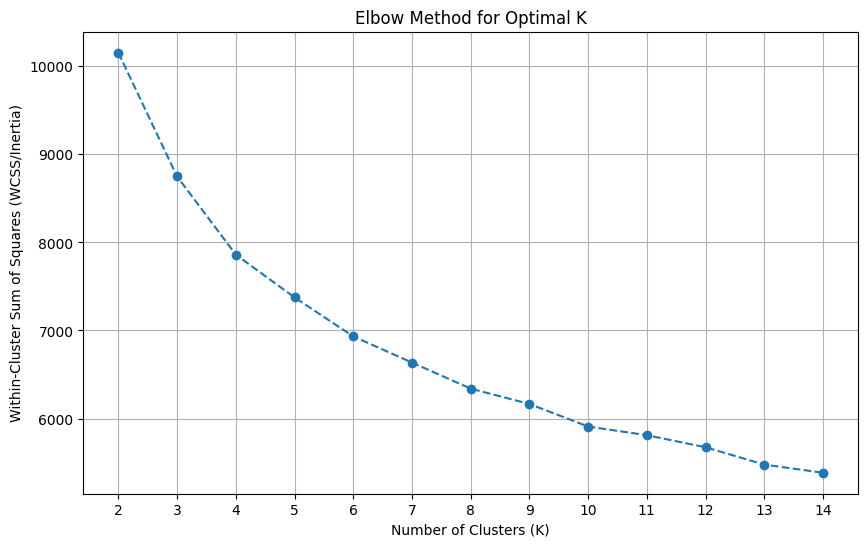

Look for the 'elbow' point in the graph where the decrease in WCSS slows significantly.


In [2]:
# Elbow Method to find optimal K
wcss = [] # Within-cluster sum of squares
k_range = range(2, 15) # Test a range of K values, typically from 2 upwards

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' or higher is good practice
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS/Inertia)')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_range)
plt.grid(True)
plt.show()

print("Look for the 'elbow' point in the graph where the decrease in WCSS slows significantly.")

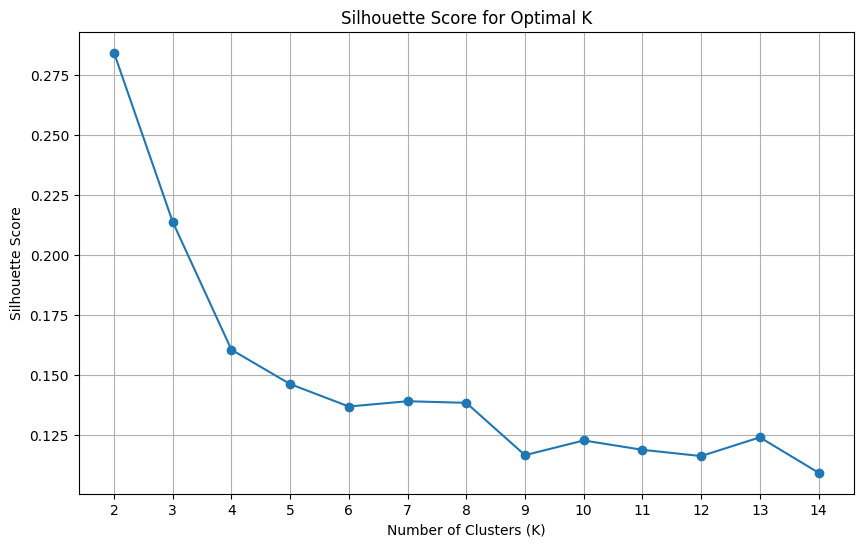

Choose the K value that yields the highest Silhouette Score.


In [3]:
# Silhouette Score Method
silhouette_scores = []

for k in k_range: # Use the same k_range as for the Elbow Method
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(score)

# Plot the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.xticks(k_range)
plt.grid(True)
plt.show()

print("Choose the K value that yields the highest Silhouette Score.")

In [4]:
# Choose your optimal K (replace with the value you determined)
optimal_k = 7 # Example: Let's assume 7 clusters seems reasonable from the plots. YOU WILL CHANGE THIS.

# Initialize and fit K-Means
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(df_scaled)

# Add cluster labels to your original (player_info) DataFrame
player_info['Cluster'] = cluster_labels

# You can also add it to the scaled DataFrame if needed for further analysis
df_scaled['Cluster'] = cluster_labels

print(f"\nK-Means clustering completed with K = {optimal_k}.")
print("First 10 players with their assigned clusters:")
print(player_info[['Player', 'Team', 'Pos', 'Cluster']].head(10))

# Get the cluster centroids (the "average" player for each archetype)
# These centroids are in the scaled feature space
cluster_centers_scaled = kmeans_model.cluster_centers_


K-Means clustering completed with K = 7.
First 10 players with their assigned clusters:
            Player Team Pos  Cluster
0    Mikal Bridges  NYK  SF        1
1        Josh Hart  NYK  SG        3
2  Anthony Edwards  MIN  SG        0
3     Devin Booker  PHO  SG        0
4     James Harden  LAC  PG        0
5    DeMar DeRozan  SAC  SF        0
6       Trae Young  ATL  PG        0
7      Tyler Herro  MIA  SG        0
8       OG Anunoby  NYK  PF        1
9      Jalen Green  HOU  SG        0



--- Cluster Mean Feature Values (Unscaled, if df_original_all_features was unscaled) ---
               PTS       AST        TRB       STL       BLK       TOV  \
Cluster                                                                 
0        32.147059  8.131373   7.880392  1.715686  0.637255  3.727451   
1        20.983471  3.777686   7.063636  1.443802  0.701653  1.905785   
2        23.527273  8.753030   6.272727  1.910606  0.616667  3.807576   
3        31.515000  6.210000  14.820000  1.660000  1.830000  3.310000   
4        17.371642  4.265672   6.768657  1.576119  0.652239  2.373134   
5        18.926667  3.602222  16.324444  1.302222  2.284444  2.586667   
6        19.090909  4.221212  11.134848  2.115152  1.325758  2.486364   

               PF       FG%       3P%       2P%  ...      BLK%       TOV%  \
Cluster                                          ...                        
0        2.833333  0.468824  0.363882  0.536843  ...  1.229412  11.929412   
1        3.544628  0.

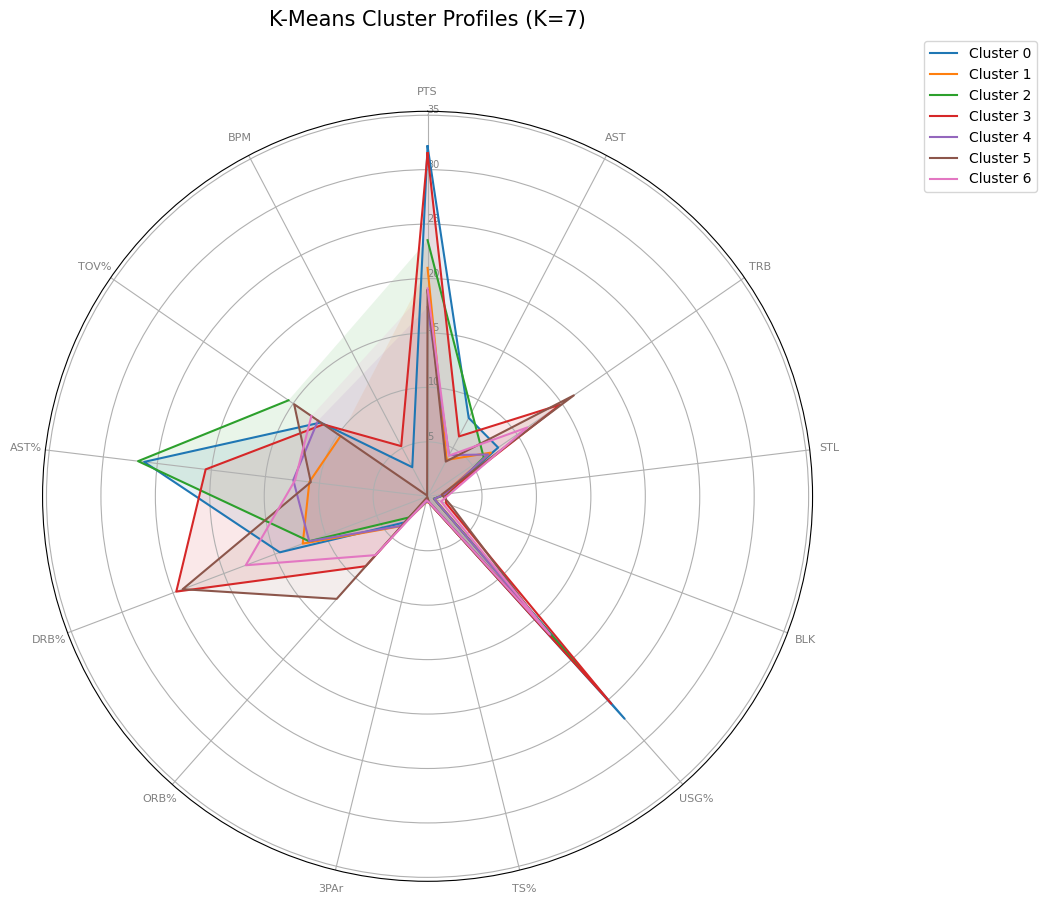


--- Players in Each Cluster ---

--- Cluster 0 ---
                       Player Team Pos  Cluster   PER
49  Luka Don\uc0\u269 i\u263   2TM  PG        0  24.2
52  Luka Don\uc0\u269 i\u263   DAL  PG        0  24.2
55  Luka Don\uc0\u269 i\u263   LAL  PG        0  24.2
54  Luka Don\uc0\u269 i\u263   LAL  PG        0  24.1
48  Luka Don\uc0\u269 i\u263   2TM  PG        0  24.1
51  Luka Don\uc0\u269 i\u263   DAL  PG        0  24.1
56  Luka Don\uc0\u269 i\u263   LAL  PG        0  23.9
50  Luka Don\uc0\u269 i\u263   2TM  PG        0  23.9
53  Luka Don\uc0\u269 i\u263   DAL  PG        0  23.9
70                Joel Embiid  PHI   C        0  23.4
Total players in Cluster 0: 71

--- Cluster 1 ---
              Player Team Pos  Cluster   PER
34    Quentin Grimes  DAL  SG        1  18.8
31    Quentin Grimes  2TM  SG        1  18.8
151    Chris Boucher  TOR  PF        1  18.7
5        Zach LaVine  SAC  SG        1  18.4
158         Jay Huff  MEM   C        1  18.2
111       Obi Toppin  IND  PF     

In [5]:

# 1. Average (Mean) Feature Values for Each Cluster
# To interpret, it's often best to look at the original (unscaled) values.
# Ensure `final_df` is available from your data_preparation notebook (or loaded here if needed).
# If you didn't save `df_clustering` (the unscaled, imputed features), you might need to
# re-load `final_df` and re-apply the feature selection and imputation steps *without* scaling
# to get `df_original_features_for_interpretation`.

# For this example, assuming 'final_df' (the original, unscaled, filtered data with player info)
# is available, or you load it similarly to player_info if you saved it.
# If you saved df_clustering (after imputation but before scaling) as a separate CSV:
# df_original_features_for_interpretation = pd.read_csv('path/to/df_clustering_unscaled_imputed.csv')
# For simplicity, let's assume `final_df` from `01_data_preparation.ipynb` is the base.

# Make sure the players are in the same order as df_scaled for correct cluster assignment
# (if they were perfectly aligned before saving df_scaled and player_info, this is fine).
# A robust way is to re-merge the cluster labels with the player_info and then select original features.

# Create a DataFrame with original features and cluster labels for interpretation
# This assumes that `player_info` contains `PLAYER`, `TEAM`, `POS`, `AGE` and that
# `final_df` (the pre-scaled dataframe with all original features) is either loaded or
# its relevant columns can be accessed.
# To be safe, let's load `nba_2025_player_stats.csv` which was the result of merging and initial filtering in notebook 01,
# BEFORE feature selection and scaling.
# Adjust the path as per where you saved this full, unscaled dataframe.
# If you didn't save this intermediate dataframe, you might need to adapt.
try:
    # Assuming this CSV contains all original, merged, filtered, and imputed columns
    # (i.e., it's 'final_df' after imputation from 01_data_preparation.ipynb)
    df_original_all_features = pd.read_csv('../data/processed/nba_2025_player_stats_merged_cleaned.csv') # You might need to create this file in NB 01
    df_original_all_features['Cluster'] = cluster_labels # Add the assigned cluster labels
except FileNotFoundError:
    print("Warning: 'nba_2025_player_stats_merged_cleaned.csv' not found. "
          "Using df_clustering (which is already scaled) for interpretation of feature means, "
          "which is less ideal for direct interpretation of magnitudes.")
    df_original_all_features = df_scaled.copy() # Fallback, but be aware these are scaled values
    df_original_all_features['Cluster'] = cluster_labels


# If you need to filter df_original_all_features to only the columns that were used for clustering (i.e., `df_clustering.columns`)
# to ensure consistent feature sets for interpretation of means.
features_used_for_scaling = df_scaled.drop(columns=['Cluster']).columns.tolist() # Get the feature names
cluster_interpretation_df = df_original_all_features[features_used_for_scaling + ['Cluster']].copy()


cluster_means = cluster_interpretation_df.groupby('Cluster').mean()
print("\n--- Cluster Mean Feature Values (Unscaled, if df_original_all_features was unscaled) ---")
print(cluster_means)

# 2. Visualize Cluster Profiles (Radar Charts or Bar Charts)
# (Same function as provided previously)
def plot_cluster_profiles(cluster_means_df, features_to_plot, title="Cluster Profiles"):
    num_clusters = cluster_means_df.shape[0]
    num_features = len(features_to_plot)

    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    angles += angles[:1] # Complete the circle

    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111, polar=True)

    for i in range(num_clusters):
        values = cluster_means_df.loc[i, features_to_plot].tolist()
        values += values[:1] # Complete the circle

        ax.plot(angles, values, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], features_to_plot, color='grey', size=8)
    ax.set_rlabel_position(0)
    plt.yticks(color="grey", size=7)
    plt.ylim(0, cluster_means_df[features_to_plot].max().max() * 1.1) # Adjust y-lim dynamically
    plt.title(title, size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# Select a subset of key features for the radar chart for better readability
# (Ensure these features are in your `cluster_interpretation_df.columns` or `df_scaled.columns` if you fall back to scaled means)
key_features_for_radar = [
    'PTS', 'AST', 'TRB', 'STL', 'BLK', 'USG%', 'TS%', '3PAr', 'ORB%', 'DRB%', 'AST%', 'TOV%', 'BPM'
]
# Ensure these features exist in your cluster_means
key_features_for_radar = [f for f in key_features_for_radar if f in cluster_means.columns]

plot_cluster_profiles(cluster_means, key_features_for_radar, title=f"K-Means Cluster Profiles (K={optimal_k})")


# 3. Examine Specific Players within Each Cluster
print("\n--- Players in Each Cluster ---")
for cluster_id in range(optimal_k):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_players = player_info[player_info['Cluster'] == cluster_id].copy() # Ensure you're working on a copy

    # Merge PER back if not already in player_info for sorting (from the original data)
    # This assumes 'final_df' (or a similar comprehensive unscaled df) is available.
    # If not, you might need to adjust where 'PER' comes from.
    if 'PER' in df_original_all_features.columns:
        cluster_players = pd.merge(cluster_players, df_original_all_features[['Player', 'PER']], on='Player', how='left')
        cluster_players = cluster_players.sort_values(by='PER', ascending=False)
    elif 'MP' in df_original_all_features.columns: # Fallback to minutes played
        cluster_players = pd.merge(cluster_players, df_original_all_features[['Player', 'MP']], on='Player', how='left')
        cluster_players = cluster_players.sort_values(by='MP', ascending=False)
    else:
        print(f"Warning: No 'PER' or 'MP' for sorting players in Cluster {cluster_id}. Displaying unsorted.")


    print(cluster_players.head(10)[['Player', 'Team', 'Pos', 'Cluster'] + (['PER'] if 'PER' in cluster_players.columns else ['MP'] if 'MP' in cluster_players.columns else []) ])
    print(f"Total players in Cluster {cluster_id}: {len(cluster_players)}")

# 4. Create meaningful names for each archetype based on analysis
# This is a manual step based on your interpretation of the means and players.
# E.g., "Rim-Running Bigs," "3-and-D Wings," "All-Star Playmakers," etc.

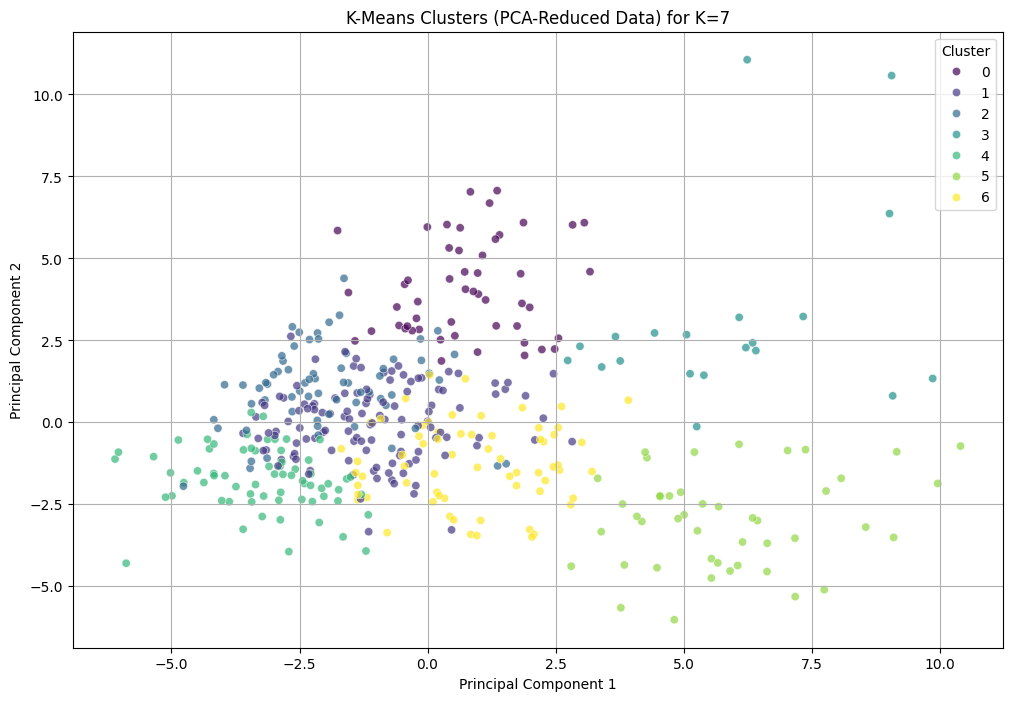


PCA Explained Variance Ratio:
[0.32629197 0.19795656]
Total variance explained by 2 components: 0.52


In [6]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
# Ensure df_scaled still has its original feature columns (without the 'Cluster' column itself)
# We created df_scaled['Cluster'] for convenience, so drop it for PCA input.
pca_input_df = df_scaled.drop(columns=['Cluster']) if 'Cluster' in df_scaled.columns else df_scaled.copy()
pca = PCA(n_components=2) # Reduce to 2 principal components
principal_components = pca.fit_transform(pca_input_df)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels
pca_df['Player'] = player_info['Player'] # Add player names for hover/annotation (if using interactive plots)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis',
    data=pca_df,
    legend='full',
    alpha=0.7
)
plt.title(f'K-Means Clusters (PCA-Reduced Data) for K={optimal_k}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

print("\nPCA Explained Variance Ratio:")
print(pca.explained_variance_ratio_)
print(f"Total variance explained by 2 components: {pca.explained_variance_ratio_.sum():.2f}")